In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mp
import matplotlib.pyplot as plt
import math as m
import sympy as smp
from IPython.display import display as disp
import lablib as ll
%matplotlib inline

In [2]:
data = {}
work = {}

kinds = ["heating", "cooling"]
colors = {
    "heating": "#800000",
    "cooling": "#000080"
}

constants = ll.read_csv("constants.csv")

for kind in kinds:
    data[kind] = ll.read_csv("measurements/%s.csv" % kind)
    work[kind] = ll.varlist()
    ll.add(work[kind],
           constants)

for kind in kinds:
    disp("Data for kind %s" % kind, data[kind])

for kind in kinds:
    disp("Working variables for kind %s" % kind, work[kind])

'Data for kind heating'

,T,Error_T,h_upper,h_lower,h_lower_condensate,Error_h
0,299.15,0.05,0.10600,0.07390,0.17475,0.0005
1,300.15,0.05,0.10680,0.07345,0.17420,0.0005
2,301.15,0.05,0.10755,0.07270,0.17360,0.0005
3,302.15,0.05,0.10830,0.07200,0.17280,0.0005
4,303.15,0.05,0.10930,0.07100,0.17210,0.0005
5,304.15,0.05,0.11030,0.07020,0.17110,0.0005
6,305.15,0.05,0.11120,0.06920,0.17040,0.0005
7,306.15,0.05,0.11220,0.06840,0.16920,0.0005
8,307.15,0.05,0.11320,0.06740,0.16800,0.0005
9,308.15,0.05,0.11435,0.06630,0.16690,0.0005


'Data for kind cooling'

,T,Error_T,h_upper,h_lower,h_lower_condensate,Error_h
0,309.15,0.05,0.1150,0.0644,0.1644,0.0005
1,307.15,0.05,0.1127,0.0667,0.1664,0.0005
2,305.15,0.05,0.1107,0.0686,0.1680,0.0005
3,303.15,0.05,0.1086,0.0704,0.1697,0.0005


'Working variables for kind heating'

,Value,Error
T_boil,373.00000,5.000000e-01
d_hg_20,13546.00000,5.000000e-01
d_hg_40,13497.00000,5.000000e-01
d_h2o_20,998.20000,5.000000e-02
d_h2o_40,992.20000,5.000000e-02
g,9.82030,5.000000e-05
R,8.31446,5.000000e-08


'Working variables for kind cooling'

,Value,Error
T_boil,373.00000,5.000000e-01
d_hg_20,13546.00000,5.000000e-01
d_hg_40,13497.00000,5.000000e-01
d_h2o_20,998.20000,5.000000e-02
d_h2o_40,992.20000,5.000000e-02
g,9.82030,5.000000e-05
R,8.31446,5.000000e-08


In [3]:
#
# density = (density_40 - density_20)/20 * T + (density_20 - 293.15/20 * (density_40 - density_20))
#

# we will account for changing densities of liquids inside of the mercury barometer
def model_density(T, d_40, d_20):
    return ((d_40 - d_20) / 20) * T + (d_20 - 293.15/20 * (d_40 - d_20))

# this function calculates pressure at given temperature and given barometer readings
# we pass constants as arguments because we would like to calculate the error accounting uncertainties of all
# participating data, including reference point densities and the gravitational acceleration
def model_pressure(h_upper, h_lower, h_lower_condensate, T, d_hg_40, d_hg_20, d_h2o_40, d_h2o_20, g):
    # density_hg * g * h
    # density_hg * g * (h_upper - h_lower)
    # density_hg * g * h_upper - density_hg * g * h_lower - density_h2o * g * h_condensate
    # g * (density_hg * (h_upper - h_lower) - density_h2o * h_condensate)
    density_hg = model_density(T, d_hg_40, d_hg_20)
    density_h2o = model_density(T, d_h2o_40, d_h2o_20)
    return g * (density_hg * (h_upper - h_lower) - density_h2o * (h_lower_condensate - h_lower))

sym_h_u, sym_h_l, sym_h_l_c, sym_T, sym_d_hg_40, sym_d_hg_20, sym_d_h2o_40, sym_d_h2o_20, sym_g = \
    smp.symbols("h_upper h_lower h_lower_condensate T d_hg_40 d_hg_20 d_h2o_40 d_h2o_20 g")

sym_pressure = model_pressure(h_upper = sym_h_u,
                              h_lower = sym_h_l,
                              h_lower_condensate = sym_h_l_c,
                              T = sym_T,
                              d_hg_40 = sym_d_hg_40,
                              d_hg_20 = sym_d_hg_20,
                              d_h2o_40 = sym_d_h2o_40,
                              d_h2o_20 = sym_d_h2o_20,
                              g = sym_g)

sym_pressure_cols_mapping = {
    "h_upper": {
        "Value": "h_upper",
        "Error": "Error_h"
    },
    "h_lower": {
        "Value": "h_lower",
        "Error": "Error_h"
    },
    "h_lower_condensate": {
        "Value": "h_lower_condensate",
        "Error": "Error_h"
    },
    "T": {
        "Value": "T",
        "Error": "Error_T"
    }
}

for kind in kinds:
    data[kind]["P"], data[kind]["Error_P"] = ll.sym_compute_column("pressure",
                                                                   sym_pressure,
                                                                   work[kind],
                                                                   sym_pressure_cols_mapping,
                                                                   data[kind])
    disp("Data for %s" % kind, data[kind])

'Data for heating'

,T,Error_T,h_upper,h_lower,h_lower_condensate,Error_h,P,Error_P
0,299.15,0.05,0.10600,0.07390,0.17475,0.0005,3278.681858,90.700094
1,300.15,0.05,0.10680,0.07345,0.17420,0.0005,3445.256561,90.684040
2,301.15,0.05,0.10755,0.07270,0.17360,0.0005,3642.534088,90.667988
3,302.15,0.05,0.10830,0.07200,0.17280,0.0005,3835.543885,90.651937
4,303.15,0.05,0.10930,0.07100,0.17210,0.0005,4097.605906,90.635892
5,304.15,0.05,0.11030,0.07020,0.17110,0.0005,4337.906339,90.619848
6,305.15,0.05,0.11120,0.06920,0.17040,0.0005,4586.509051,90.603808
7,306.15,0.05,0.11220,0.06840,0.16920,0.0005,4828.585829,90.587771
8,307.15,0.05,0.11320,0.06740,0.16800,0.0005,5095.159149,90.571741
9,308.15,0.05,0.11435,0.06630,0.16690,0.0005,5392.849587,90.555718


'Data for cooling'

,T,Error_T,h_upper,h_lower,h_lower_condensate,Error_h,P,Error_P
0,309.15,0.05,0.1150,0.0644,0.1644,0.0005,5736.077297,90.539705
1,307.15,0.05,0.1127,0.0667,0.1664,0.0005,5130.482179,90.571742
2,305.15,0.05,0.1107,0.0686,0.1680,0.0005,4617.363844,90.603809
3,303.15,0.05,0.1086,0.0704,0.1697,0.0005,4101.919080,90.635891


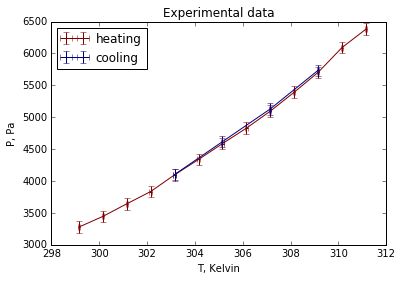

In [4]:
plt.title("Experimental data")
plt.ylabel("P, Pa")
plt.xlabel("T, Kelvin")

for kind in kinds:
    plt.errorbar(x = data[kind]["T"], y = data[kind]["P"],
                 xerr = data[kind]["Error_T"], yerr = data[kind]["Error_P"],
                 label = kind, color = colors[kind])

plt.legend(loc = "best")

In [5]:
def model_lnP(P):
    return smp.log(P)

def model_invT(T):
    return 1/T

sym_P, sym_T = smp.symbols("P T")

sym_lnP = model_lnP(sym_P)
sym_invT = model_invT(sym_T)

sym_lnP_cols_mapping = {
    "P": {
        "Value": "P",
        "Error": "Error_P"
    }
}

sym_invT_cols_mapping = {
    "T": {
        "Value": "T",
        "Error": "Error_T"
    }
}

for kind in kinds:
    data[kind]["lnP"], data[kind]["Error_lnP"] = ll.sym_compute_column("pressure logarithm",
                                                                       sym_lnP,
                                                                       work[kind],
                                                                       sym_lnP_cols_mapping,
                                                                       data[kind])
    data[kind]["invT"], data[kind]["Error_invT"] = ll.sym_compute_column("inverse absolute temp",
                                                                       sym_invT,
                                                                       work[kind],
                                                                       sym_invT_cols_mapping,
                                                                       data[kind])
    disp("Data for %s" % kind, data[kind])

'Data for heating'

,T,Error_T,h_upper,h_lower,h_lower_condensate,Error_h,P,Error_P,lnP,Error_lnP,invT,Error_invT
0,299.15,0.05,0.10600,0.07390,0.17475,0.0005,3278.681858,90.700094,8.095197,0.027664,0.003343,5.587171e-07
1,300.15,0.05,0.10680,0.07345,0.17420,0.0005,3445.256561,90.684040,8.144754,0.026321,0.003332,5.550004e-07
2,301.15,0.05,0.10755,0.07270,0.17360,0.0005,3642.534088,90.667988,8.200435,0.024891,0.003321,5.513207e-07
3,302.15,0.05,0.10830,0.07200,0.17280,0.0005,3835.543885,90.651937,8.252067,0.023635,0.003310,5.476774e-07
4,303.15,0.05,0.10930,0.07100,0.17210,0.0005,4097.605906,90.635892,8.318158,0.022119,0.003299,5.440701e-07
5,304.15,0.05,0.11030,0.07020,0.17110,0.0005,4337.906339,90.619848,8.375147,0.020890,0.003288,5.404983e-07
6,305.15,0.05,0.11120,0.06920,0.17040,0.0005,4586.509051,90.603808,8.430874,0.019754,0.003277,5.369616e-07
7,306.15,0.05,0.11220,0.06840,0.16920,0.0005,4828.585829,90.587771,8.482309,0.018761,0.003266,5.334595e-07
8,307.15,0.05,0.11320,0.06740,0.16800,0.0005,5095.159149,90.571741,8.536046,0.017776,0.003256,5.299916e-07
9,308.15,0.05,0.11435,0.06630,0.16690,0.0005,5392.849587,90.555718,8.592829,0.016792,0.003245,5.265573e-07


'Data for cooling'

,T,Error_T,h_upper,h_lower,h_lower_condensate,Error_h,P,Error_P,lnP,Error_lnP,invT,Error_invT
0,309.15,0.05,0.1150,0.0644,0.1644,0.0005,5736.077297,90.539705,8.654531,0.015784,0.003235,5.231564e-07
1,307.15,0.05,0.1127,0.0667,0.1664,0.0005,5130.482179,90.571742,8.542955,0.017654,0.003256,5.299916e-07
2,305.15,0.05,0.1107,0.0686,0.1680,0.0005,4617.363844,90.603809,8.437579,0.019622,0.003277,5.369616e-07
3,303.15,0.05,0.1086,0.0704,0.1697,0.0005,4101.919080,90.635891,8.319210,0.022096,0.003299,5.440701e-07


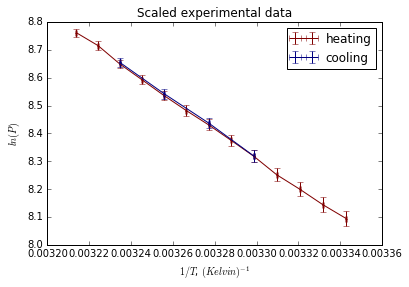

In [6]:
plt.title("Scaled experimental data")
plt.ylabel("$ln(P)$")
plt.xlabel("$1/T$, $(Kelvin)^{-1}$")

for kind in kinds:
    plt.errorbar(x = data[kind]["invT"], y = data[kind]["lnP"],
                 xerr = data[kind]["Error_invT"], yerr = data[kind]["Error_lnP"],
                 label = kind, color = colors[kind])

plt.legend(loc = "best")

In [7]:
def fit_model(x, a, b):
    return a * x + b
fit_model_args = ["dlnP_dinvT", "b"]

for kind in kinds:
    ll.add(work[kind], ll.fit(name = kind,
                              model = fit_model,
                              model_args = fit_model_args,
                              x = data[kind]["invT"],
                              y = data[kind]["lnP"],
                              xerr = data[kind]["Error_invT"],
                              yerr = data[kind]["Error_lnP"]))

Initial guesses for heating:                  Error        Value
dlnP_dinvT  138.546045 -5242.665475
b             0.451865    25.610182


'Final guesses for heating:'

,Error,Value
dlnP_dinvT,36.933330,-5242.309414
b,0.120468,25.609017


Initial guesses for cooling:                  Error        Value
dlnP_dinvT  393.717077 -5200.710942
b             1.283826    25.476966


'Final guesses for cooling:'

,Error,Value
dlnP_dinvT,66.750438,-5200.837667
b,0.217666,25.477379


In [9]:
def model_Qev(R, dlnP_dinvT):
    return -R*dlnP_dinvT

sym_R, sym_dlnP_dinvT = smp.symbols("R dlnP_dinvT")

sym_Qev = model_Qev(sym_R, sym_dlnP_dinvT)

for kind in kinds:
    ll.add(work[kind], ll.sym_compute("Qev", sym_Qev, work[kind]))

    disp("Q_ev for %s:" % kind, work[kind].loc[["Qev"]])

'Error influence estimations for Qev:'

,Error,Derivative,(E*D)^2
R,5e-08,5242.30941367356,6.87045199717261e-8
dlnP_dinvT,36.9333,-8.31445980000000,94298.5496706083


'Q_ev for heating:'

,Value,Error
Qev,43586.970879,307.080689


'Error influence estimations for Qev:'

,Error,Derivative,(E*D)^2
R,5e-08,5200.83766698595,6.76217810958495e-8
dlnP_dinvT,66.7504,-8.31445980000000,308018.151604729


'Q_ev for cooling:'

,Value,Error
Qev,43242.155708,554.99383
